<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Nombre y Apellido: Rodrigo Alejandro Tirapegui

***
## Procesos aleatorios


<div class="alert alert-block alert-info">
    
### Recepción de una señal degrada

+ ##### Un receptor de comunicaciones posee un frontend analógico que recibe señales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial.
+ ##### El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.
+ ##### Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100. La modulación empleada es antipodal:
> ###### pulso positivo -> bit 1
> ###### pulso negativo -> bit 0

### Notas:

+ ##### La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
+ ##### Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

</div>

<div class="alert alert-block alert-info">
    
### Objetivos principales:

+ ##### Detectar la secuencia de bits recibida de forma confiable. 

+ ##### Investigar diferentes métodos de demodulación.

</div>

<div class="alert alert-block alert-info">
    
#### PARTE 1

##### a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes.  ¿Es óptimo el filtro elegido para detectar la información en forma confiable?

</div>

Se presentan dos señales en los archivos signal.npy y signalLowSNR.npy. Además, se presenta una tercera señal con los pulsos de forma exponencial utilizados en la modulación PAM de las primeras dos señales.

A continuación se grafica cada una de las señales a analizar:

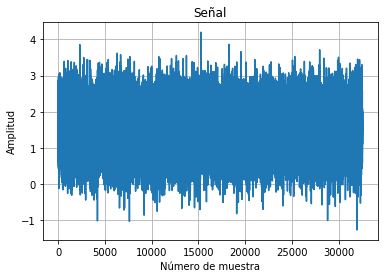

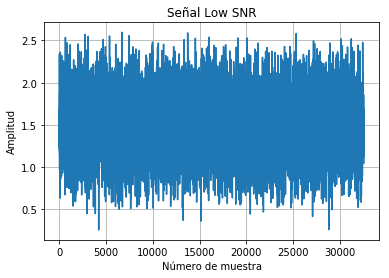

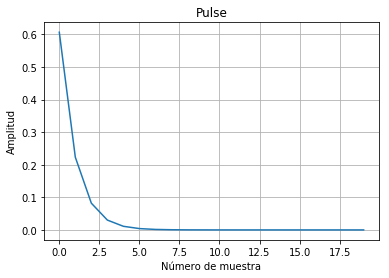

In [3]:
#%% Inicializacion
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fftpack as sc

#%% Generacion de señales

# Obtención de datos
signal = np.load('signal.npy')
signalLowSNR = np.load('signalLowSNR.npy')
pulse = np.load('pulse.npy')

# Graficado de señales
figures = ['Señal', 'Señal Low SNR', 'Pulse']
xlabel = 'Número de muestra'
ylabel = 'Amplitud'

plt.close('all')

# Señal
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(signal)

# Señal Low SNR
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(signalLowSNR)

# Pulse
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(pulse)



Con el objetivo de determinar la plantilla del filtro a diseñar para eliminar la potencia de ruido, se procede a analizar el espectro del pulso de forma exponencial.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<StemContainer object of 3 artists>

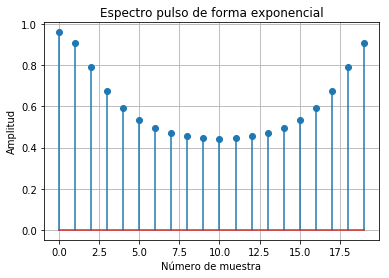

In [4]:
# Calculo del espectro del pulso
S_pulse = np.fft.fft(pulse)

# Graficado del espectro de la señal pulso
plt.figure()
plt.title('Espectro pulso de forma exponencial')
plt.xlabel('Número de muestra')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')
plt.stem(S_pulse)

Dado que la trama digitalizada fue muestreada a 20 samples/pulso, y dado que el teorema de Nyquist demuestra que la reconstrucción exacta de una señal periódica a partir de sus muestras es posible si la tasa de muestreo es superior al doble de su ancho de banda $(2B)$, puede decirse que en la digitalización se utilizó una relación de sobremuestreo de la señal $M = 20$, donde $M = f_{os}/f_s$, con $f_{os}$ igual a la frecuencia de sobremuestreo y $f_s = f_{Ny} = 2B$.

Por lo tanto, el grafico precedente muestra el espectro de la señal pulso en el rango $[0,f_{os}]$, siendo la muestra $N = 10$ la correspondiente a la frecuencia $f_{os}/2$.

De este modo, como lo que se busca es eliminar la potencia de ruido presente hasta el ancho de banda de la señal, se decide utilizar la técnica de $sobremuestreo + decimación$.

En términos generales, la $decimación$ es el proceso combinado de filtrado y reducción de la resolución lo cual, en la práctica, implica el filtrado pasa bajo de una señal y luego desechar algunas de sus muestras (proceso conocido como $downsampling$).

Esta técnica es típicamente usada (por ejemplo) por los conversores A/D del tipo sigma-delta, debido a la sencillez del filtro antialias y a la significativa reducción del ruido de cuantización que permiten lograr.

<img src="./Oversampling filtering.png" align="center" width="50%" />

En este sentido, dado que $f_s = f_{os}/M$, si se normaliza el gráfico a $f_{os} = 1$, entonces $f_s = 0.05$, y $B = f_s/2 = 0.025$.

Por lo tanto, se decide utilizar el toolbox PyFDA para diseñar un filtro que cumpla con la siguiente plantilla:

> + $f_{PB} = 0.025$
> + $f_{SB} = 0.5$

En relación con la distorsión en la banda de paso, se define como alteración máxima admisible 0,01 dB, resultando:

> + $A_{PB}[dB] = 0.01$

En relación con la atenuación mínima en la banda de atenuación, se propone que la amplitud de ruido represente como máximo el 0,1% de la amplitud de la señal, lo que determina:

> + $A_{SB}[dB] = 60$

Luego, se aplica el filtro obtenido a la señal en cuestión, y se elimina una cada M muestras ($M:1↓$) con los objetivos de reducir la frecuencia de muestreo a un valor cercano a la de Nyquist y de eliminar la potencia de ruido por fuera de la banda base.


Para implementar la parte de filtrado pasa bajo pueden utilizarse los filtros FIR o IIR.

Dado que en el caso de los FIR cualquier salida es una función sólo de las entradas anteriores (porque no hay retroalimentación), sólo hay que calcular las salidas que se utilizarán. En cambio, en los IIR, debe realizarse parte o la totalidad del cálculo del filtro para cada entrada, incluso cuando no se usará la salida correspondiente.

Por lo tanto, el hecho de que solo se deban calcular las salidas que se utilizaran es una razón para implementar un filtro FIR en lugar de un IIR.

Además, como lo que se busca es analizar las muestras temporales luego del proceso de $decimación$, resulta conveniente implementar un FIR en lugar de un IIR, dado que al ser los primeros de fase lineal (y por lo tanto, de retardo de grupo constante), distorsionan menos la señal de entrada.

> + Se diseñó un filtro pasabajos FIR de orden N = 8 utilizando la técnica equiripple. 

Se grafican a continuación las primeras 128 muestras de las señales digitalizadas filtradas signal.npy y signalLowSNR.npy.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<StemContainer object of 3 artists>

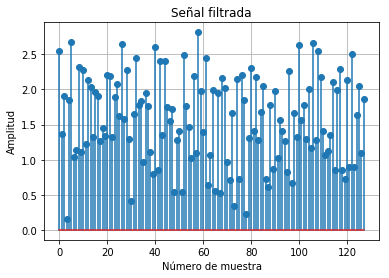

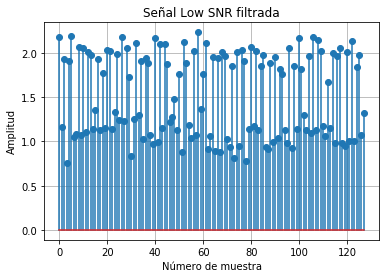

In [5]:
# Obtención del filtro FIR antialias y filtado
data = np.load('FIR_FAA.npz')
h_lp = data['ba']
b_lp = h_lp[0]
a_lp = h_lp[1]
signal_lp_filtered = sig.filtfilt(b_lp, a_lp, signal);
signalLowSNR_lp_filtered = sig.filtfilt(b_lp, a_lp, signalLowSNR);

# Decimación
signal_filtered = signal_lp_filtered[1::20]
signalLowSNR_filtered = signalLowSNR_lp_filtered[1::20]

# Graficado de las señales filtradas
figures = ['Señal filtrada', 'Señal Low SNR filtrada']
xlabel = 'Número de muestra'
ylabel = 'Amplitud'

# Señal filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signal_filtered[:128])

# Señal Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signalLowSNR_filtered[:128])


En relación con la pregunta, 

> + ¿Es óptimo el filtro elegido para detectar la información en forma confiable?

se propone analizar cuanta energía de ruido es eliminada por el filtro implementado, dado que el filtro óptimo será aquél que permita maximizar la relación señal-a-ruido de la señal ($SNR$).

La energía de la señal viene dada por la ecuación:

> + $∑𝑓_s/2𝑓=0|𝑋(𝑓)|2$

In [6]:
# Cálculo de la energía de señal original
S_signal = np.fft.fft(signal)
N_signal = len(S_signal)
energy_SignalOriginal = sum(np.power(np.abs(S_signal[:N_signal//2]), 2))             

# Calculo del espectro de la señal Low SNR
S_signalLowSNR = np.fft.fft(signalLowSNR)
N_signalLowSNR = len(S_signalLowSNR)
energy_SignalLowSNROriginal = sum(np.power(np.abs(S_signalLowSNR[:N_signalLowSNR//2]), 2))             

# Calculo la energía de la señal filtrada con FIR_FAA
S_signalFIR_FAA = np.fft.fft(signal_lp_filtered)
energy_SignalFIRFAA = sum(np.power(np.abs(S_signalFIR_FAA[:N_signal//2]), 2))             

# Calculo la energía de la señal Low SNR filtrada con FIR_FAA
S_signalLowSNRFIR_FAA = np.fft.fft(signalLowSNR_lp_filtered)
energy_SignalLowSNRFIRFAA = sum(np.power(np.abs(S_signalLowSNRFIR_FAA[:N_signalLowSNR//2]), 2))             

# Calculo energía de la señal decimada
S_signalDec = np.fft.fft(signal_filtered)
energy_SignalDec = sum(np.power(np.abs(S_signalDec[:N_signal//2]), 2))             

# Calculo energíad de la señal Low SNR decimada
S_signalLowSNRDec = np.fft.fft(signalLowSNR_filtered)
energy_SignalLowSNRDec = sum(np.power(np.abs(S_signalLowSNRDec[:N_signalLowSNR//2]), 2))             

# Impresión de los resultados
print(energy_SignalOriginal)
print(energy_SignalFIRFAA)
print(energy_SignalDec)
print(energy_SignalLowSNROriginal)
print(energy_SignalLowSNRFIRFAA)
print(energy_SignalLowSNRDec)


2585943972.0894594
2502818713.6628294
7009855.355229896
2416862474.425469
2405379419.1402087
6543215.11594499


Analizando los resultados previos se observa que para la señal:

> + #### Signal.npy

-> El filtro FIR_FAA: reduce en un 3,3% la energía de ruido de la señal original
-> El filtro FIR_FAA + downsampling: reducen en un 99.72% la energía de ruido de la señal original

> + #### SignaLowSNR.npy

-> El filtro FIR_FAA: reduce en un 4,8% la energía de ruido de la señal original
-> El filtro FIR_FAA + downsampling: reducen en un 99.72% la energía de ruido de la señal original


##### El filtro FIR utilizado no es óptimo, dado que no permite maximizar la relación señal a ruido ($SNR$). Como se verá en la Parte 2, es el filtro adaptado quien permite lograr dicho requerimiento.

<div class="alert alert-block alert-info">
    
#### PARTE 1

##### b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿Es óptimo ese umbral?

</div>

In [ ]:
Con el objetivo de determinar el umbral para tomar decisiones, se calcula y grafica el espectro de las señales filtradas.

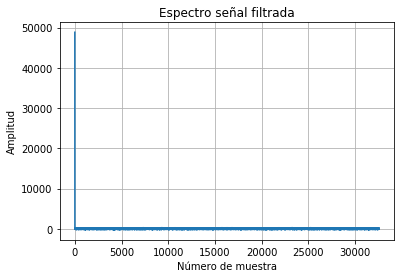

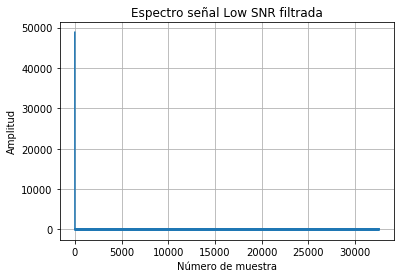

In [7]:
# Calculo del espectro de la señal
S_signal = np.fft.fft(signal)

# Calculo del espectro de la señal Low SNR
S_signalLowSNR = np.fft.fft(signalLowSNR)

# Graficado de los espectros de las señales filtradas
figures = ['Espectro señal filtrada', 'Espectro señal Low SNR filtrada']
xlabel = 'Número de muestra'
ylabel = 'Amplitud'

# Señal filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(S_signal)

# Señal Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(S_signalLowSNR)


In [ ]:
Se observa que ambas están montadas sobre una continua, y se decide calcular la media como un estimador de dicha continua.

In [8]:
# Media de señal
mean_signal = np.mean(signal_filtered)
print(mean_signal)

# Media de señal Low SNR
mean_signalLowSNR = np.mean(signalLowSNR_filtered)
print(mean_signalLowSNR)

1.5032038756584587
1.499998349572931


In [ ]:
Se reconstruye la trama digitalizada y se analizan los resultados:

In [50]:
# Elimino la continua de las señales filtradas
signal_filtered = signal_filtered - mean_signal
signalLowSNR_filtered = signalLowSNR_filtered - mean_signalLowSNR

# Genero la trama digitalizada de señal
digitalBurst_signal = signal_filtered
digitalBurst_signalLowSNR = signalLowSNR_filtered

digitalBurst_signal[digitalBurst_signal > 0] = 1
digitalBurst_signal[digitalBurst_signal < 0] = 0

# Genero la trama digitalizada de señal Low SNR
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR > 0] = 1
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR < 0] = 0

print(digitalBurst_signal[:128].reshape(16,8))
print(digitalBurst_signalLowSNR[:128].reshape(16,8))

[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]]
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]


##### Se observa que en la decodificación de la señal signal.npy el header detectado difiere del original en 14 bits; mientras que para el caso de la señal signalLowSNR.npy es error es de 1 bit.

##### Como en ambos casos se detectaron errores de demodulación, puede inferirse que el umbral elegido no es óptimo. 

<div class="alert alert-block alert-info">
    
#### PARTE 2

##### Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral óptimo.

</div>

El problema de detectar pulsos transmitidos sobre un canal AWGN (Additive White Gaussian Noise), en el cual el ruido afecta de forma independiente a cada muestra de señal, se reduce al diseño de un filtro que permita minimizar los efectos del ruido a su salida, con el objetivo de maximizar la detección del pulso de señal.

Tal filtro se denomina "Filtro Adaptado" (Matched Filter) y es comunmente utilizado en los sistemas de comunicación, dado que permite maximizar la relación señal a ruido ($SNR$), minimizando la probabilidad de errores en la detección de la señal.

El filtro adaptado se obtiene mediante la correlación de un señal retardada conocida (plantilla), con una señal desconocida; lo que equivale a convolusionar la señal desconocida con una versión conjugada invertida en el tiempo de la plantilla.

Se grafican a continuación las primeras 128 muestras de las señales digitalizadas filtradas signal.npy y signalLowSNR.npy.

<StemContainer object of 3 artists>

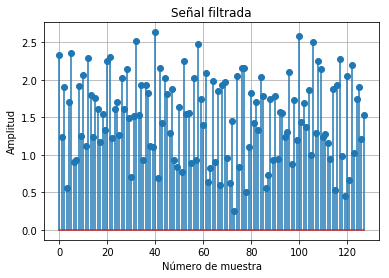

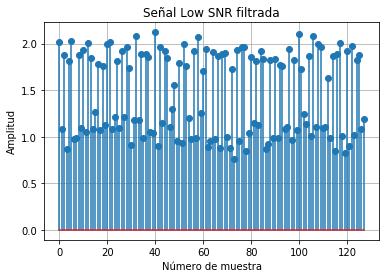

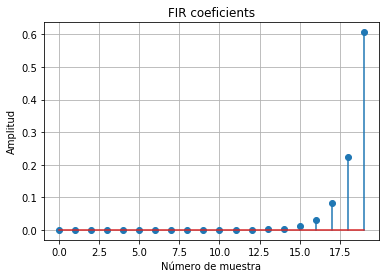

In [29]:
#%% Create FIR coeficients by time reversing the template
template = pulse[::-1]

#%% Filter signal with time reverse template
signal_MFfiltered = sig.convolve(template, signal)

#%% Filter signal Low SNR with time reverse template
signalLowSNR_MFfiltered = sig.convolve(template, signalLowSNR)

#%% Downsampling
signal_filtered = signal_MFfiltered[20::20]
signalLowSNR_filtered = signalLowSNR_MFfiltered[20::20]

#%% Grafico de resultados
figures = ['Señal filtrada', 'Señal Low SNR filtrada', 'FIR coeficients']
xlabel = 'Número de muestra'
ylabel = 'Amplitud'

for figure in figures:
    plt.close(figure)

# Señal filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signal_filtered[:128])

# Señal Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signalLowSNR_filtered[:128])

# Plantilla
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(template)

En relación con la pregunta, 

> + ¿Es óptimo el filtro elegido para detectar la información en forma confiable?

nuevamente se propone analizar cuanta energía de ruido es eliminada por el filtro implementado, dado que el filtro óptimo será aquél que permita maximizar la relación señal-a-ruido de la señal ($SNR$).

La energía de la señal viene dada por la ecuación:

> + $∑𝑓_s/2𝑓=0|𝑋(𝑓)|2$

In [30]:
# Calculo la energía de la señal filtrada con FIR_MATCHED
S_signalFIR_MATCHED = np.fft.fft(signal_MFfiltered)
energy_SignalFIRMATCHED = sum(np.power(np.abs(S_signalFIR_MATCHED[:N_signal//2]), 2))             

# Calculo la energía de la señal Low SNR filtrada con FIR_FAA
S_signalLowSNRFIR_MATCHED = np.fft.fft(signalLowSNR_MFfiltered)
energy_SignalLowSNRFIRMATCHED = sum(np.power(np.abs(S_signalLowSNRFIR_MATCHED[:N_signalLowSNR//2]), 2))             

# Calculo energía de la señal decimada
S_signalDec = np.fft.fft(signal_filtered)
energy_SignalDec = sum(np.power(np.abs(S_signalDec[:N_signal//2]), 2))             

# Calculo energíad de la señal Low SNR decimada
S_signalLowSNRDec = np.fft.fft(signalLowSNR_filtered)
energy_SignalLowSNRDec = sum(np.power(np.abs(S_signalLowSNRDec[:N_signalLowSNR//2]), 2))             

# Impresión de los resultados
print(energy_SignalOriginal)
print(energy_SignalFIRMATCHED)
print(energy_SignalDec)
print(energy_SignalLowSNROriginal)
print(energy_SignalLowSNRFIRMATCHED)
print(energy_SignalLowSNRDec)


2585943972.0894594
2282427347.643971
6332656.38960299
2416862474.425469
2211162887.0828385
6001493.481337001


Analizando los resultados previos se observa que para la señal:

> + #### Signal.npy

-> El filtro FIR_MATCHED: reduce en un 11,8% la energía de ruido de la señal original
-> El filtro FIR_MATCHED + downsampling: reducen en un 99.75% la energía de ruido de la señal original

> + #### SignaLowSNR.npy

-> El filtro FIR_MATCHED: reduce en un 8,5% la energía de ruido de la señal original
-> El filtro FIR_MATCHED + downsampling: reducen en un 99.75% la energía de ruido de la señal original


##### A diferencia del filtro utilizado en la Parte 1, el filtro adaptado es óptimo, lo cual puede derivarse utilizando el argumento geométrico:

##### La intuición detrás del filtro adaptado se basa en la correlación de la señal recibida (un vector) con un filtro (otro vector) que es paralelo a la señal (maximizando el producto interno, lo que mejora la señal), y ortogonal al ruido (lo que atenúa el ruido presente).

Con el objetivo de determinar el umbral para tomar decisiones, se calculan las probabilidades de medir una amplitud $x$ a la salida del filtro adaptado, para los casos en que se sabe se envió un 1 ó un 0; es decir, $P(x/1)$ y $P(x/0)$, sobre los primeros 128 bits de la señal filtrada y submuestreada (correpondiente al header conocido de 16 bytes), para ambas señales.

(array([ 1.,  1.,  1.,  8.,  7., 16., 11., 11.,  3.,  5.]),
 array([1.55276496, 1.60959537, 1.66642578, 1.72325618, 1.78008659,
        1.83691699, 1.8937474 , 1.95057781, 2.00740821, 2.06423862,
        2.12106903]),
 <a list of 10 Patch objects>)

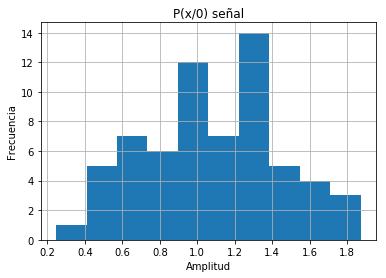

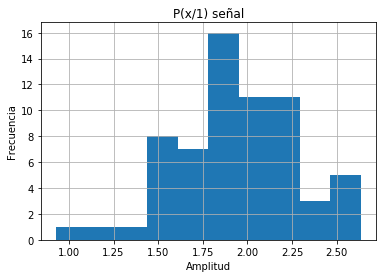

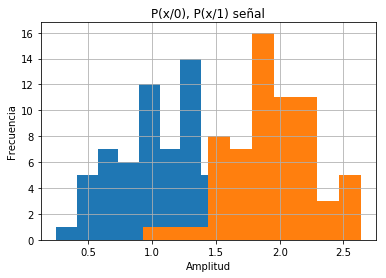

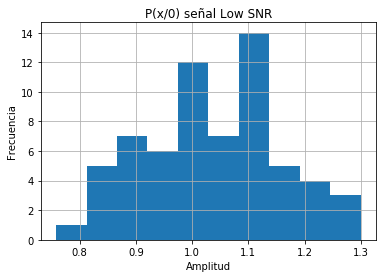

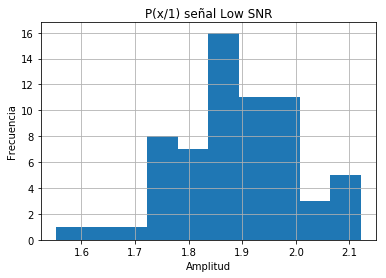

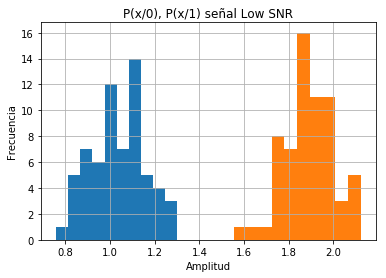

In [31]:
# Arreglos con amplitudes correpondientes a los bits 1 y 0 para la señal signal.npy
signal_zeros = []
signal_ones = []

# Arreglos con amplitudes correpondientes a los bits 1 y 0 para la señal signalLowSNR.npy
signalLowSNR_zeros = []
signalLowSNR_ones = []

for i in range(0, 128):
    byte_no = np.floor(i/8)*8
    if( ((i % 2 == 0) & (i % (byte_no + 6) != 0)) | (i % (byte_no + 5) == 0) ):
        signal_ones.append(signal_filtered[i])
        signalLowSNR_ones.append(signalLowSNR_filtered[i])
    else:
        signal_zeros.append(signal_filtered[i])
        signalLowSNR_zeros.append(signalLowSNR_filtered[i])

# Grafico de resultados
figures = ['P(x/0) señal', 'P(x/1) señal', 'P(x/0), P(x/1) señal', 'P(x/0) señal Low SNR', 'P(x/1) señal Low SNR', 'P(x/0), P(x/1) señal Low SNR']
xlabel = 'Amplitud'
ylabel = 'Frecuencia'

for figure in figures:
    plt.close(figure)

# P(x/0) señal
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_zeros)

# P(x/1) señal
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_ones)

# P(x/0), P(x/1) señal
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_zeros)
plt.hist(signal_ones)

# P(x/0) señal Low SNR
plt.figure(figures[3])
plt.title(figures[3])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_zeros)

# P(x/1) señal Low SNR
plt.figure(figures[4])
plt.title(figures[4])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_ones)

# P(x/0), P(x/1) señal
plt.figure(figures[5])
plt.title(figures[5])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_zeros)
plt.hist(signalLowSNR_ones)


En base a los histogramas, se observa lo siguiente:

> + #### SignaLowSNR.npy

Las probabilidades de medir determinada amplitud al haber enviado 1 ó 0 no se solapan, con lo cual es posible determinar un umbral óptimo que permita demodular los bits con 100% de efectividad.

Dicho umbral podría considerarse como la media entre los desvíos máximos de las probabilidades graficadas, es decir:

> + $Umbral_{amplitud} = (1.3 + 1.55)/2 = 1.425$ 

> + #### Signal.npy

Las probabilidades de medir determinada amplitud al haber enviado 1 ó 0 se solapan en el rango de amplitudes $[0,75, 1,9]$, con lo cual no es posible determinar un umbral óptimo que permita demodular los bits con 100% de efectividad.

No obstante, lo más conveniento a fin de reducir el error de detección es seleccionar la aplitud para la cual ambas curvas de probabilidad se pisan, es decir:

> + $Umbral_{amplitud} = 1.425$ 

In [ ]:
Se reconstruye la trama digitalizada y se analizan los resultados:

In [32]:
# Elimino la continua de las señales filtradas
signal_filtered = signal_filtered - 1.425
signalLowSNR_filtered = signalLowSNR_filtered - 1.425

# Genero la trama digitalizada de señal
digitalBurst_signal = signal_filtered
digitalBurst_signalLowSNR = signalLowSNR_filtered

digitalBurst_signal[digitalBurst_signal > 0] = 1
digitalBurst_signal[digitalBurst_signal < 0] = 0

# Genero la trama digitalizada de señal Low SNR
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR > 0] = 1
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR < 0] = 0

print(digitalBurst_signal[:128].reshape(16,8))
print(digitalBurst_signalLowSNR[:128].reshape(16,8))

[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]]
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]


##### Se observa que en la decodificación de la señal signal.npy el header detectado nuevamente difiere del original en 14 bits; mientras que para el caso de la señal signalLowSNR.npy, ahora la efectividad es del 100%.

#### En ambos casos, el umbral de decisión elegido es óptimo (el mejor posible).